### Code Along Project Steps
- Read in the Data <br>
- Feature Engineering <br>
    * Calculate Distance
    * Derive useful Date and Time statistics
- Deal with the Categorical Data (Embedding) 
- Use a TabularModel class to work with both continuous and categorical data 


- Create the TabularModel Steps
- Add in loss function and optimizer
- Train/Test split the data
- Train the model 
- Evaluate on test data
- Predict on brand new data

# Feature Engineering

In [2]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


## Load the NYC Taxi Fares dataset
The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. It is up to the contest participant to extract any further information. For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

In [3]:
df = pd.read_csv("C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data/NYCTaxiFares.csv")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

## Calculate the distance traveled
The haversine formula calculates the distance on a sphere between two sets of GPS coordinates

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head() 

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


# Add a datetime column and derive useful statistics




In [7]:
"""
Creat a datetime object >> extract information like "day of the week", "am vs. pm"
"""
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours =4) # savings time in NewYork >> adjust to EDT using UTC-4
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [8]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [9]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

# Separate categorical from continuous columns

In [10]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [11]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount'] # contains the labels

# Category

In [12]:
"""
Pandas offers a category dtype for converting categorical values to numerical codes 
months of the year <=>12 codes (integers 0 to 11) 
Pandas replaces the column values with codes and retain an index list of category values
"""

# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [13]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [14]:
df['Hour'].head() # the codes assigned to each name 

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

access the category names with <tt>Series.cat.categories</tt> or just the codes with <tt>Series.cat.codes</tt>. This will make more sense if we look at <tt>df['AMorPM']</tt>:

In [15]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [16]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [17]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [18]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [19]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

### NaN values in categorical data are assigned a code of -1

In [20]:
#Combine the three categorical columns into one input array using numpy.stack
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [21]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

# Convert numpy arrays to tensors

In [22]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [23]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [24]:
conts.type()

'torch.FloatTensor'

In [25]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [26]:
cats.shape

torch.Size([120000, 3])

In [27]:
conts.shape

torch.Size([120000, 6])

In [28]:
y.shape

torch.Size([120000, 1])

# Set an embedding size

In [29]:
"""
The rule of thumb for determining the embedding size is to
divide the number of unique entries in each column by 2, but not to exceed 50.
"""
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

# Define a TabularModel

Goal: define a model based on the number of continuous columns (conts.shape[1]) plus the number of categorical 
columns(len(emb_szs) )and their embeddings(emb_szs)

The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). <br>
For this exercise our output will be a single regression value. <br>
Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.</strong><br>

1. Extend the base Module class, set up the following parameters:
   * <tt>emb_szs: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_sz:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer (for simplicity we'll use the same value throughout)
   
<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the embedded layers with <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> and <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a><br>Categorical data will be filtered through these Embeddings in the forward section.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Set up a dropout function for the embeddings with <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> The default p-value=0.5<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Set up a normalization function for the continuous variables with <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (we'll use <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>), a normalization step, and a dropout layer. We'll combine the list of layers with <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before passing them through the layers.<br>Use <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> to combine multiple tensors into one.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

In [30]:
# This is source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [31]:
# This is passed in when the model is instantiated
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [32]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [33]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [34]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-0.8095, -0.7359, -1.6082, -0.6775,  0.6848, -2.1725,  2.0076, -0.0861,
           0.8940,  1.6467,  1.8293,  0.7185],
         [ 0.1241, -0.7404, -0.2750, -2.0980, -0.8642,  2.6051,  0.1987,  0.0595,
           0.2112,  0.3128,  0.4559,  2.2122],
         [-1.4521,  0.3706, -1.4718,  0.4685, -0.6241, -0.5258,  0.5617,  2.2317,
          -2.3955, -1.0722,  0.9915,  1.1190],
         [-1.1380,  0.7590, -0.5011,  0.4996, -0.2154,  0.1787,  0.6080,  0.7758,
          -0.6816, -0.1056,  0.4658, -0.0750]], grad_fn=<EmbeddingBackward>),
 tensor([[1.5146],
         [1.5146],
         [1.5146],
         [0.1985]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.3853, -0.0111, -0.1760, -1.1922],
         [ 0.9189,  0.3388, -0.2649,  0.1090],
         [ 0.9189,  0.3388, -0.2649,  0.1090],
         [ 0.9551, -2.3090, -0.3441,  0.1479]], grad_fn=<EmbeddingBackward>)]

In [35]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[-0.8095, -0.7359, -1.6082, -0.6775,  0.6848, -2.1725,  2.0076, -0.0861,
          0.8940,  1.6467,  1.8293,  0.7185,  1.5146, -0.3853, -0.0111, -0.1760,
         -1.1922],
        [ 0.1241, -0.7404, -0.2750, -2.0980, -0.8642,  2.6051,  0.1987,  0.0595,
          0.2112,  0.3128,  0.4559,  2.2122,  1.5146,  0.9189,  0.3388, -0.2649,
          0.1090],
        [-1.4521,  0.3706, -1.4718,  0.4685, -0.6241, -0.5258,  0.5617,  2.2317,
         -2.3955, -1.0722,  0.9915,  1.1190,  1.5146,  0.9189,  0.3388, -0.2649,
          0.1090],
        [-1.1380,  0.7590, -0.5011,  0.4996, -0.2154,  0.1787,  0.6080,  0.7758,
         -0.6816, -0.1056,  0.4658, -0.0750,  0.1985,  0.9551, -2.3090, -0.3441,
          0.1479]], grad_fn=<CatBackward>)

In [36]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [37]:
z = selfembdrop(z)
z

tensor([[-0.0000, -0.0000, -2.6804, -1.1292,  0.0000, -0.0000,  3.3460, -0.0000,
          0.0000,  2.7446,  0.0000,  0.0000,  2.5243, -0.6421, -0.0000, -0.0000,
         -1.9870],
        [ 0.0000, -0.0000, -0.4583, -3.4967, -1.4404,  4.3418,  0.0000,  0.0992,
          0.3520,  0.0000,  0.7599,  3.6870,  0.0000,  0.0000,  0.0000, -0.4415,
          0.1817],
        [-2.4202,  0.0000, -0.0000,  0.7808, -1.0402, -0.0000,  0.9361,  0.0000,
         -3.9925, -1.7869,  1.6525,  0.0000,  2.5243,  1.5315,  0.5647, -0.4415,
          0.1817],
        [-0.0000,  1.2649, -0.8351,  0.8326, -0.0000,  0.0000,  1.0133,  1.2930,
         -1.1359, -0.0000,  0.0000, -0.1250,  0.0000,  1.5919, -3.8483, -0.5735,
          0.0000]], grad_fn=<MulBackward0>)

<div class="alert alert-danger"><strong>This is how the categorical embeddings are passed into the layers.</strong></div>

In [38]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [39]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [40]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [41]:
#Define loss function and optimizer
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
# Train/Test split
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [43]:
len(cat_train)

48000

In [44]:
len(cat_test)

12000

# Train the model 

In [45]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.49953079
epoch:  26  loss: 11.52666759
epoch:  51  loss: 10.47162437
epoch:  76  loss: 9.53090572
epoch: 101  loss: 8.72837734
epoch: 126  loss: 7.81541204
epoch: 151  loss: 6.70775080
epoch: 176  loss: 5.48522472
epoch: 201  loss: 4.37022400
epoch: 226  loss: 3.70549846
epoch: 251  loss: 3.51685023
epoch: 276  loss: 3.44736743
epoch: 300  loss: 3.42487454

Duration: 1226 seconds


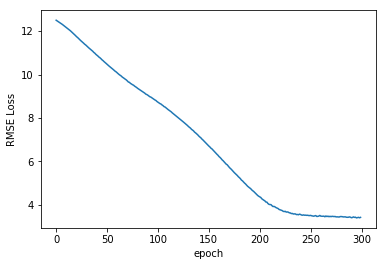

In [46]:
# Plot the loss function
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [47]:
#Validate the model
#chạy model qua toàn bộ tập test và so sánh với những nhãn đã biết
#ở bước này ko muốn cập nhật weights and biases nên set torch.no_grad()
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.34569192


In [48]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   2.5258   2.9000   0.3742
 2.  25.0885   5.7000  19.3885
 3.   6.3869   7.7000   1.3131
 4.  13.5297  12.5000   1.0297
 5.   4.4957   4.1000   0.3957
 6.   4.9116   5.3000   0.3884
 7.   3.1296   3.7000   0.5704
 8.  17.7939  14.5000   3.2939
 9.   6.1307   5.7000   0.4307
10.  12.0632  10.1000   1.9632
11.   6.0902   4.5000   1.5902
12.   6.8988   6.1000   0.7988
13.   5.9466   6.9000   0.9534
14.  13.4745  14.1000   0.6255
15.   5.9154   4.5000   1.4154
16.  27.5576  34.1000   6.5424
17.   3.3297  12.5000   9.1703
18.   5.7631   4.1000   1.6631
19.   8.2568   8.5000   0.2432
20.   6.2824   5.3000   0.9824
21.  13.6508  11.3000   2.3508
22.   9.6946  10.5000   0.8054
23.  16.0124  15.3000   0.7124
24.  19.2758  14.9000   4.3758
25.  48.6202  49.5700   0.9498
26.   6.3326   5.3000   1.0326
27.   6.0473   3.7000   2.3473
28.   7.1369   6.5000   0.6369
29.  15.0696  14.1000   0.9696
30.   6.7617   4.9000   1.8617
31.   4.3687   3.7000   0.6687
32.  35.

In [49]:
#Save the model 
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/ANN/TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')


In [50]:
#Loading a saved model
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

In [51]:
"""
Now define the model. Before we can load the saved settings,
 we need to instantiate our TabularModel with the parameters we used 
before (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value). 

"""


'\nNow define the model. Before we can load the saved settings,\n we need to instantiate our TabularModel with the parameters we used \nbefore (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value). \n\n'

In [52]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

In [53]:
#Once the model is set up, loading the saved settign is a snap
model2.load_state_dict(torch.load('C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/ANN/TaxiFareRegrModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [54]:
"""
Function that takes in new parameters from the user, performs all of the 
processing steps above and passes the new data through trained model
"""

def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')